This investigates the time taken for a given KN event to be observed.

In [4]:
import numpy as np
import random
from astropy import units as u
from astropy.coordinates import SkyCoord
import scipy
import os
import matplotlib.pylab as plt
%matplotlib inline

from parse_simlib import parse_simlib
from python_utilities.des_io import parse_observations

In [8]:
#Creates a list of all pointings, with [LIBID, RA, DECL, MJD IDEXPT  FLT GAIN NOISE SKYSIG (pixels)  RATIO  ZPTAVG ZPTERR  MAG]
os.chdir('/data/des41.a/data/jaortiz/snana-test/')

libid_details, pointings = parse_simlib('simlibs/minion_1016_WFD.simlib')

print len(pointings)

2083758


In [8]:
#create random KN events
num_locations = 10000
KN_locations = np.zeros([num_locations,3])
for i in range(len(sky_locations)):
    KN_locations[i,:] = [random.uniform(59804,63180.9), random.uniform(0,360), random.uniform(-62,2)]
    #this range of values for DECL and PEAKMJD is the same range as those simulated in snana


In [ ]:

def whisker_plot(data, no_obs, obs_made, t1):
    bands = ['u', 'g', 'r', 'i', 'z', 'Y']
    
    fig1 = plt.figure('boxplot_min_ang_perband', figsize=(9,9))
    #plt.title('Box plot of angular separation of nearest pointing in a given \n band in the %i hrs following a trigger' %(t1*24), fontsize=20)
#    plt.title('Percentage of events with no observation in next %i hours. u:%i %%, g:%i %%, r:%i %%, i:%i %%, z:%i %%, Y:%i %%. \
#              \n Horizontal line is at $sqrt(9/ \pi)$ deg. Percentage of events below green line: u:%.1f %%, g:%.1f %%, r:%.1f %%, i:%.1f %%, z:%.1f %%, Y:%.1f %%.' 
#              %(t1*24, no_obs[0],no_obs[1],no_obs[2],no_obs[3],no_obs[4],no_obs[5], \
#               obs_made[0],obs_made[1],obs_made[2],obs_made[3],obs_made[4],obs_made[5]) )
    plt.boxplot(data, labels=bands, showfliers=False)
    plt.ylabel('Angular separation (degrees)', size=20)
    


    for i in range(len(bands)): #add scatter of points
        y = data[i]
        x = np.random.normal(1+i, 0.04, size=len(y))
        plt.plot(x, y, 'r.', alpha=0.4)
    plt.hlines(np.sqrt(9.6/np.pi), 0, 6.5, color='green', alpha=0.6)
    plt.ylim(ymin=-5)
    plt.xlabel('Filter', size=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    fig1.savefig('do_swaps/boxplot')
    return


In [65]:
#use KN locations of simulated events in snana
def load_KN_locs(DIR): #load locations and times of all DAT files for KN in given directory 
    file_count = len([f for f in os.walk(DIR).next()[2] if f[-4:] == ".DAT"])
    KN_locations = np.zeros([file_count, 3])

    file_num = 0
    for file in os.listdir(DIR):  # run through all .dat files in the specified directory
        if file.endswith(".DAT"):
            obs, headerdict = parse_observations(DIR + file)
            KN_locations[file_num,:] = [headerdict['PEAKMJD'], headerdict['RA'], headerdict['DECL']]
            file_num += 1
    return KN_locations

KN_locations = load_KN_locs('../GW170817_AT2017gfo_LSST_WFD/')


In [107]:
time_taken = np.zeros(len(KN_locations))
time_taken[:] = np.nan

for i, KN in enumerate(KN_locations):
    
    #get pointings in the next week
    pointings_later = pointings[KN[0]<pointings[:,3], :]
    pointings_nextweek = pointings_later[pointings_later[:,3]<(KN[0]+3)]
    if len(pointings_nextweek) == 0: #if no pointings in the next 24hrs
        continue
    
    #get angles between all of pointings and KN
    kilonova_loc = SkyCoord(ra=KN[1] * u.degree, dec=KN[2] * u.degree)
    pointings_locs = SkyCoord(ra=pointings_nextweek[:,1] * u.degree, dec=pointings_nextweek[:,2] * u.degree)
    angsep = kilonova_loc.separation(pointings_locs).deg
    observations_arg = np.argwhere(angsep<3)
    if len(observations_arg) == 0:
        continue
    mjd_observed = pointings_nextweek[observations_arg[0],:][0][3]

    time_taken[i] = mjd_observed - KN[0]

print time_taken
    

[ 1.7928  0.0355  0.9516  0.6599  0.5323  0.4729  0.3174  0.9797  0.1503
  0.2544  0.1764  1.1296     nan  0.354   0.874   0.4151  0.4977  0.4521
  0.1165  0.2535  0.1416  1.9549  0.4802  0.7546  2.7974  0.3535  2.0999
  0.8043  0.9141  0.6069  0.9845  1.6836  0.2057  2.8146  0.2697  0.026
  1.7897  0.1479     nan  0.21    0.9329  0.2649  2.7758  1.2376  0.4342
  2.4936  0.2936  0.1987     nan  0.0123  1.945   0.1148  0.2822  0.5378
  0.1168  0.6447  1.0549  0.3409  0.063   0.0222  0.5457  0.1391     nan
  0.6827  1.3493  0.5274  0.8613  0.7098  0.1057  0.6186  0.3024  0.9983
  1.445   0.4303  0.2393     nan  0.3683  0.2661  1.608   0.411   0.0125
     nan     nan  0.3291  0.217      nan  1.2346  1.5668     nan     nan
  1.6479  0.5908  0.5234  0.4555  0.6721  0.2433  0.3897  0.2281  1.4193
  0.6459  0.1522  1.6101  0.0092  1.1927  0.5069  0.3459  1.5227  0.3571
  1.5528  2.3148  0.3859  0.0161  2.3742  0.254   2.1717  0.8265  0.7422
  0.6363  1.7417  0.3153     nan  0.7103  2.3821  0.

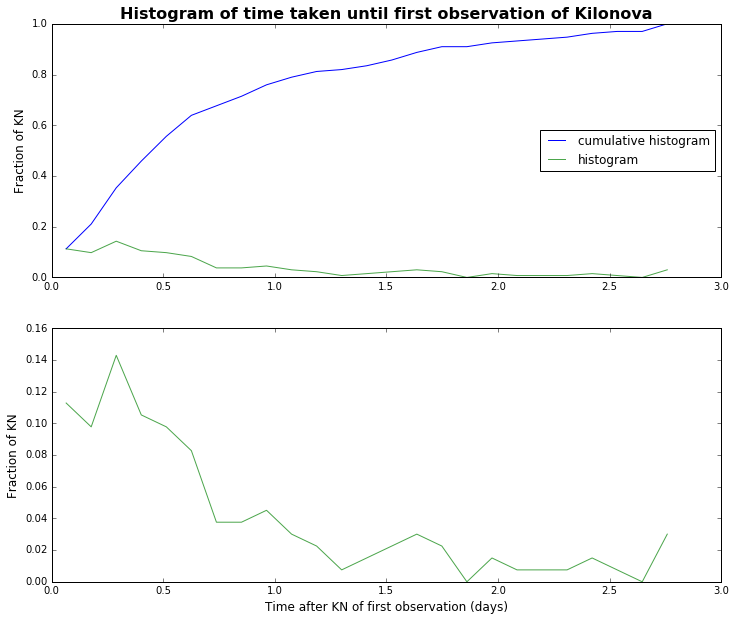

In [160]:
#plot histogram
histdata, binedges = np.histogram(time_taken[~np.isnan(time_taken)], 25)
binsize = binedges[1] - binedges[0]
bincentres = binedges[:-1] + binsize/2
histdata = histdata/float(len(time_taken[~np.isnan(time_taken)])) 

fig1 = plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(bincentres, np.cumsum(histdata), label='cumulative histogram')
plt.plot(bincentres, histdata, alpha=0.7, label='histogram')
plt.ylim([0,1])
plt.title('Histogram of time taken until first observation of Kilonova', size=16, fontweight='bold')
plt.ylabel('Fraction of KN', size=12)
plt.legend(loc= 'center right')

plt.subplot(2,1,2)
plt.plot(bincentres, histdata, alpha=0.7, label='histogram', color='g')
plt.ylabel('Fraction of KN', size=12)
plt.xlabel('Time after KN of first observation (days)', size=12)



#plt.hist(time_taken[~np.isnan(time_taken)], bins=40)
plt.show()

fig1.savefig('time_to_observe/histograms')
